<a href="https://colab.research.google.com/github/alice202122/2competitionDL/blob/main/DL_TSAssigment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#CONNECT TO DRIVE

In [ ]:
from google.colab import drive
drive.mount('/gdrive')

In [ ]:
%cd /gdrive/My Drive/AN_Assignment

#IMPORT LIBRABRIES

In [ ]:
import tensorflow as tf
import numpy as np
import os
import random
import pandas as pd
import seaborn as sns
from datetime import datetime
import matplotlib.pyplot as plt
plt.rc('font', size=16)
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_val_score
import warnings
warnings.filterwarnings('ignore')
tf.get_logger().setLevel('ERROR')

tfk = tf.keras
tfkl = tf.keras.layers
print(tf.__version__)

2.7.0


#SET SEED FOR REPRODUCIBILITY

In [ ]:
seed = 42

random.seed(seed)
os.environ['PYTHONHASHSEED'] = str(seed)
np.random.seed(seed)
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

#EXPLORATION DATA ANALYSIS

In [ ]:
dataset = pd.read_csv('Training.csv')
print(dataset.shape)
dataset.head()

(68528, 7)


,Sponginess,Wonder level,Crunchiness,Loudness on impact,Meme creativity,Soap slipperiness,Hype root
0,7.97698,4.33494,10.67282,1.76692,3.22440,51.681460,3.65434
1,8.07824,4.44616,10.56160,1.70716,3.32566,51.563598,3.47672
2,8.02844,4.22372,10.56160,1.64906,3.17460,50.863080,3.47672
3,8.02844,4.22372,10.56160,1.70716,3.17460,45.841581,3.47672
4,7.87572,4.44616,10.45038,1.70716,3.27586,47.126421,3.47672


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68528 entries, 0 to 68527
Data columns (total 7 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Sponginess          68528 non-null  float64
 1   Wonder level        68528 non-null  float64
 2   Crunchiness         68528 non-null  float64
 3   Loudness on impact  68528 non-null  float64
 4   Meme creativity     68528 non-null  float64
 5   Soap slipperiness   68528 non-null  float64
 6   Hype root           68528 non-null  float64
dtypes: float64(7)
memory usage: 3.7 MB


In [ ]:
def inspect_dataframe(df, columns):
    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(df[col])
        axs[i].set_title(col)
    plt.show()

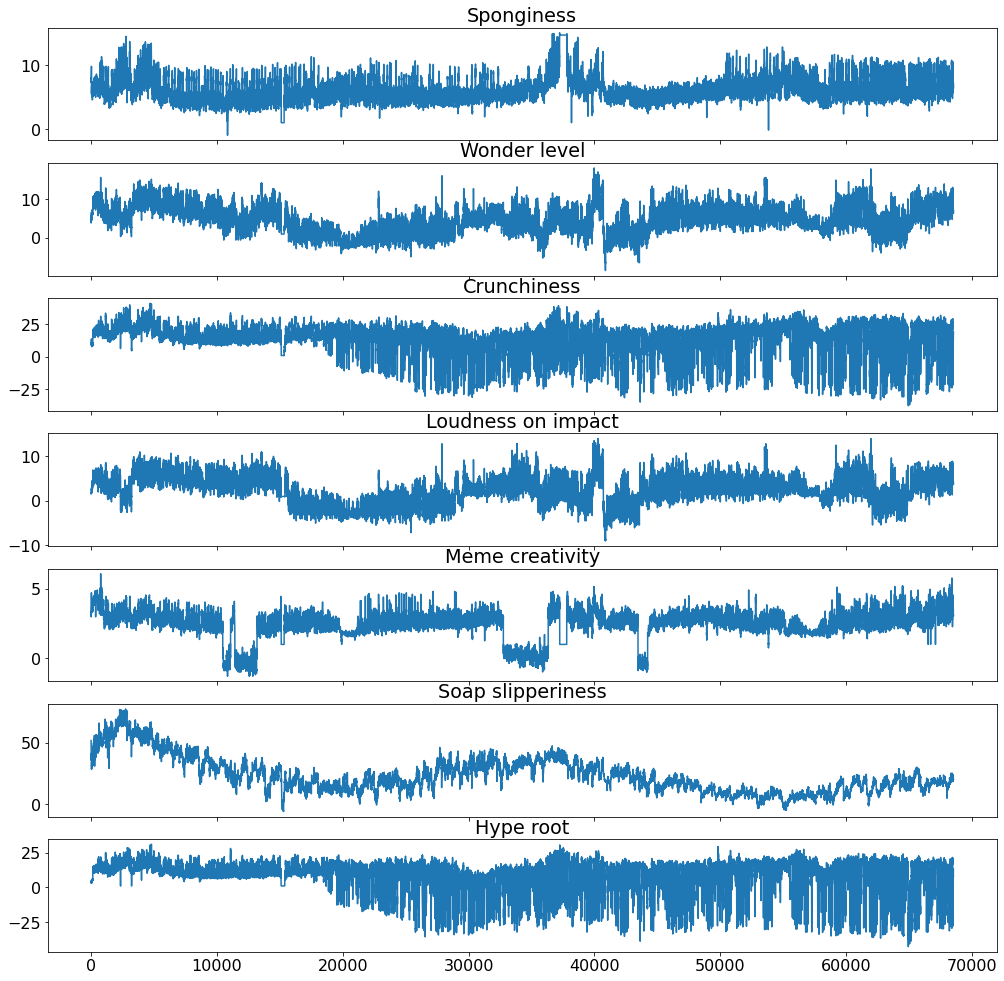

In [ ]:
inspect_dataframe(dataset, dataset.columns)

A Multivariate Time Series consist of more than one time-dependent variable and each variable depends not only on its past values but also has some dependency on other variables.

#TRAIN-TEST SPLIT

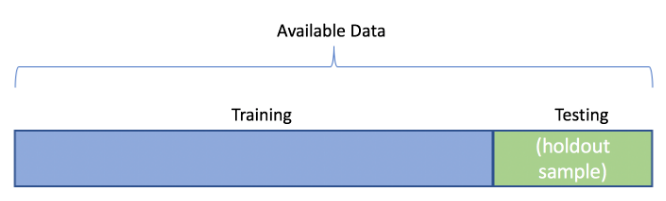

In [ ]:
test_size = int(0.2*len(dataset))
X_train_raw = dataset.iloc[:-test_size]
X_test_raw = dataset.iloc[-test_size:]
print(X_train_raw.shape, X_test_raw.shape)

(54823, 7) (13705, 7)


##Normalization

In [ ]:
X_min = X_train_raw.min()
X_max = X_train_raw.max()

X_train_raw = (X_train_raw-X_min)/(X_max-X_min)
X_test_raw = (X_test_raw-X_min)/(X_max-X_min)

##Visualization

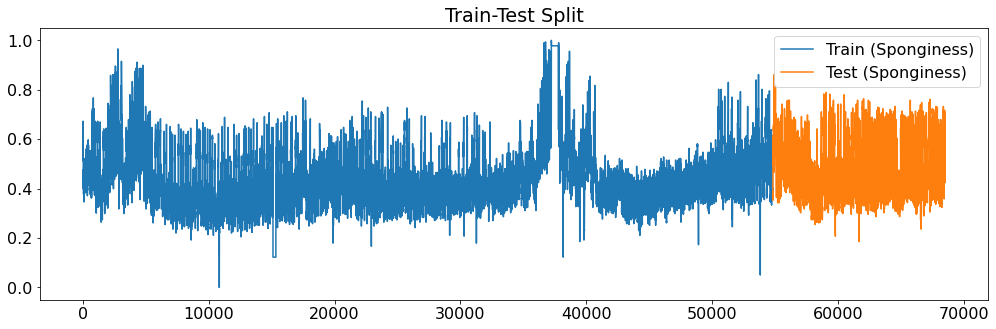

In [ ]:
plt.figure(figsize=(17,5))
plt.plot(X_train_raw.Sponginess, label='Train (Sponginess)')
plt.plot(X_test_raw.Sponginess, label='Test (Sponginess)')
plt.title('Train-Test Split')
plt.legend()
plt.show()

#MULTIVARIATE FORECASTING

Time Series forecast is about forecasting a variable’s value in future, based on its own past values.

###MODELS ARCHITECTURE

Instead of training the model to forecast next values only at the very last time step, we train it to forecast the next values at each and every time step. The advantage of this technique is that the loss will contain a term for the output at each and every time step, not only at the last time step. So there will be more error gradients flowing through the model. They will also flow from the output of each time step. This can stabilise the training process.

In [ ]:
def build_sequences(df, target_labels, window, stride, telescope):
    assert window % stride == 0   # sanity check to avoid runtime errors
    dataset = []
    labels = []
    temp_df = df.copy().values
    temp_label = df[target_labels].copy().values
    padding_len = len(df)%window

    if(padding_len != 0):
        # Compute padding length
        padding_len = window - len(df)%window
        padding = np.zeros((padding_len, temp_df.shape[1]), dtype='float64')
        temp_df = np.concatenate((padding, df))
        padding = np.zeros((padding_len, temp_label.shape[1]), dtype='float64')
        temp_label = np.concatenate((padding, temp_label))
        assert len(temp_df) % window == 0

    for idx in np.arange(0,len(temp_df)-window-telescope, stride):
        dataset.append(temp_df[idx:idx+window])
        labels.append(temp_label[idx+window:idx+window+telescope])

    dataset = np.array(dataset)
    labels = np.array(labels)
    return dataset, labels

####BASELINE METHODS

We will start modeling with creating a simple base line model which will help us evaluate advanced model performance later. It is a point of reference for all other modeling techniques, if a model achieves performance at or below the baseline, the technique should be fixed or abandoned.  The principle is that if a sophisticated forecast method cannot outperform a model that uses little or no problem-specific information, then it does not have skill.
The technique used to generate a forecast to calculate the baseline performance must be easy to implement and naive of problem-specific details.

#####Multi-step

It consists in repeating the last temporal step for the required number of temporal steps.

In [ ]:
def build_multistep_model(telescope):
  class MultiStepLastBaseline(tf.keras.Model):
    def call(self, inputs):
      return tf.tile(inputs[:, -1:, :], [1, telescope, 1])

  model = MultiStepLastBaseline()

  model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

  return model

####STARTING METHODS

#####Linear

In [ ]:
def build_linear_model(input_shape, output_shape):

    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')
    
    lambd = tf.keras.layers.Lambda(lambda x: x[:, -1:, :])(input_layer)
    
    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lambd)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

#####Dense

Before applying models that operate effectively on more temporal phases, it is worth to evaluate the performances of deeper models, therefore more powerful, but still based single temporal step input.

In [ ]:
def build_dense_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lambd = tf.keras.layers.Lambda(lambda x: x[:, -1:, :])(input_layer)
    dense = tf.keras.layers.Dense(units=512, activation='relu')(lambd)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(dense)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

#####Convolutional Neural Network (CNN)

A convolutional model (CNN) makes predictions based over a fixed length cronology, which can lead to better performances with respect to the dense model since it can account for how things change with time.

In [ ]:
def build_CNN_model(input_shape, output_shape, window):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lambd = tf.keras.layers.Lambda(lambda x: x[:, -window:, :])(input_layer)
    conv1D = tf.keras.layers.Conv1D(256, activation='relu', kernel_size=(window))(lambd)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(conv1D)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

####DEEP LEARNING METHODS

In classical methods we must take care of pre-processing of the time series data like analyzing and removing the trend, seasonality etc., from the time series without which such algorithms wouldn’t work.
Deep neural networks can learn the inherent patterns in different time series and come up with a sound model without the need to break up the trend and seasonality patterns present in the time series data.
However, you need a huge set of data to train such models. Also, neural networks involve configuration of hyper-parameters and learning-rate etc., which are not straight-forward and need some iterations and fine tuning. Training of deep learning networks is time consuming as well and need GPU for speed.

#####Simple RNN

In RNNs, each hidden layer of the neural network feeds the next layer with it’s output ( Feed Forward ) and also feeds itself the output at time step ‘t’ while training on the data at next time step ‘t+1’. That is RNN tries to learn a sequence of data, if that is relevant for the predictions the model is making, rather than independent data that a normal neural network learns.
In other words, RNNs process a time series step-by-step, maintaining an internal state from time-step to time-step.

In [ ]:
def build_RNN_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    RNN = tf.keras.layers.SimpleRNN(1, input_shape=input_shape)(input_layer)    # just one neuron

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(RNN)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

#####Deep RNN

In [ ]:
def build_DeepRNN_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    RNN = tf.keras.layers.SimpleRNN(20, return_sequences=True, input_shape=input_shape)(input_layer)
    dropout = tf.keras.layers.Dropout(rate=0.2)(RNN)    # otherwise validation loss fluctuates too much
    RNN = tf.keras.layers.SimpleRNN(20)(dropout)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(RNN)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

#####LSTM

It’s kind of RNN, but while maintaining RNN’s ability to learn the temporal dynamics of sequential data, LSTM can furthermore handle the vanishing and exploding gradients problem. Thus, complex multivariate data sequences can be accurately modeled, and the need to establish pre-specified time windows (which solves many tasks that feed-forward networks cannot solve).
LSTM is the popular variant of RNNs which solved the issues in normal RNNs like ‘Vanishing Gradients problem’ in very deep RNNs which hampers learning process in the initial layers when the error gradients are passed by back propagation through time (BPTT) in RNNs with a lot of hidden layers. LSTMs also solves the memory loss issues that normal RNNs face when the training sequences get too long.

In [ ]:
def build_LSTM20_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tf.keras.layers.LSTM(20, return_sequences=True)(input_layer)
    dropout = tf.keras.layers.Dropout(rate=0.2, seed=seed)(lstm)    # otherwise validation loss fluctuates too much
    lstm = tf.keras.layers.LSTM(20)(dropout)

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lstm)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

In [ ]:
def build_LSTM128_model(input_shape, output_shape):
    # Build the neural network layer by layer
    input_layer = tfkl.Input(shape=input_shape, name='Input')

    lstm = tfkl.LSTM(128, return_sequences=True)(input_layer)
    lstm = tfkl.LSTM(128)(lstm)
    dropout = tfkl.Dropout(rate=0.3, seed=seed)(lstm)     # otherwise validation loss fluctuates too much

    # In order to predict the next values for more than one channel,
    # we can use a Dense layer with a number given by telescope*num_channels,
    # followed by a Reshape layer to obtain a tensor of dimension 
    # [None, telescope, num_channels]
    dense = tfkl.Dense(output_shape[-1]*output_shape[-2], activation='relu')(lstm)
    output_layer = tfkl.Reshape((output_shape[-2], output_shape[-1]))(dense)
    output_layer = tfkl.Conv1D(output_shape[-1], 1, padding='same')(output_layer)

    # Connect input and output through the Model class
    model = tfk.Model(inputs=input_layer, outputs=output_layer, name='model')

    # Compile the model
    model.compile(loss=tfk.losses.MeanSquaredError(), optimizer=tfk.optimizers.Adam(), metrics=['mae'])

    # Return the model
    return model

####OTHER METHODS

#####Attention Mechanism

This is one of the basic principles of deep learning that can be adapted in terms of different forecasting models. In a nutshell, it mimics the human brain in terms of focusing attention on specific elements that stand out from a bunch. This enables a deep neural network to concentrate only on relevant data points among the barrage of various inputs, boosting the efficiency of NLP.

#####Transformer Neural Networks

A transformer neural network is an advanced architecture focused on solving sequence-to-sequence tasks. Its main goal is also to easily handle long-range dependencies. Such networks are quite popular in ML-based models, simplifying regression by simply customizing the loss function. This comes in more than handy when it comes to regressions.

##MODEL TRAINING AND EVALUATION ON VALIDATION SET

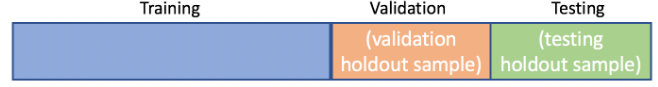

We use the EarlyStopping callback provided by Keras to stop the training process if the validation loss is not seen to be improving (decreasing) over a number of consecutive epochs.

In [ ]:
target_labels = dataset.columns
window = 200
stride = 10

In [ ]:
telescope = 1

In [ ]:
X_train, y_train = build_sequences(X_train_raw, target_labels, window, stride, telescope)
X_train.shape, y_train.shape

In [ ]:
def inspect_multivariate(X, y, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

In [ ]:
inspect_multivariate(X_train, y_train, target_labels, telescope)

In [ ]:
input_shape = X_train.shape[1:]
output_shape = y_train.shape[1:]
batch_size = 64
epochs = 200

In [ ]:
model = build_LSTM128_model(input_shape, output_shape)
model.summary()
tfk.utils.plot_model(model, expand_nested=True)

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.1,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
best_epoch = np.argmin(history['val_loss'])

plt.figure(figsize=(17,4))
plt.plot(history['loss'], label='Training loss', alpha=.8, color='#ff7f0e')
plt.plot(history['val_loss'], label='Validation loss', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Squared Error (Loss)')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(17,4))
plt.plot(history['mae'], label='Training accuracy', alpha=.8, color='#ff7f0e')
plt.plot(history['val_mae'], label='Validation accuracy', alpha=.9, color='#5a9aa5')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.title('Mean Absolute Error')
plt.legend()
plt.grid(alpha=.3)
plt.show()

plt.figure(figsize=(18,3))
plt.plot(history['lr'], label='Learning Rate', alpha=.8, color='#ff7f0e')
plt.axvline(x=best_epoch, label='Best epoch', alpha=.3, ls='--', color='#5a9aa5')
plt.legend()
plt.grid(alpha=.3)
plt.show()

##MODEL OPTIMIZATION (Cross-validation)

Because we only split the data into one set of training data and one set of validation data, the performance metrics of our models are highly reliant on those two sets. They are only trained and evaluated once so the performance depends on that one evaluation and may perform very differently when trained and evaluated on different subsets of the same data, just because of the nature of how the subsets are picked.
What if we could do this split into training and validation test multiple times, each time on different subsets of the data, train and evaluate our models each time and look at the average performance of the models across multiple evaluations? Exactly that is the idea behind K-fold Cross-Validation.
Everything apart from the test set, is split into K number of folds (subsets). The Cross-Validation then iterates through the folds and at each iteration uses one of the K folds as the validation set while using all remaining folds as the training set. This process is repeated until every fold has been used as a validation set.
By training and testing the model K number of times on different subsets of the same training data we get a more accurate representation of how well our model might perform on data it has not seen before. In a K-fold CV we score the model after every iteration and compute the average of all scores to get a better representation of how the model performs compared to only using one training and validation set.
Together to achieve a better performance estimation, cross-validation can be used too when optimizing the hyperparameters of the model itself. Unlike model parameters, which are learned during model training and can not be set arbitrarily, hyperparameters are parameters that can be set by the user before training a Machine Learning model.


##FINAL MODEL EVALUATION

We now train the model on the entire 80% of the data that we used for all of our evaluations so far, i.e. everything apart from the test set. We use the hyperparameters that we found in the previous part.

In [ ]:
history = model.fit(
    x = X_train,
    y = y_train,
    batch_size = batch_size,
    epochs = epochs,
    validation_split=.0,
    callbacks = [
        tfk.callbacks.EarlyStopping(monitor='val_loss', mode='min', patience=10, restore_best_weights=True),
        tfk.callbacks.ReduceLROnPlateau(monitor='val_loss', mode='min', patience=5, factor=0.5, min_lr=1e-5)
    ]
).history

In [ ]:
model_directory= '/gdrive/MyDrive/AN_Assignment/'
filename = 'LSTM128'
filename_chosen = os.path.join(model_directory, filename)
model.save(filename_chosen + '.h5')

##MODEL TESTING

We finally evaluate how the model performs on the test set, that is testing data with known results — a step necessary for making sure the picked algorithm does its work properly.

In [ ]:
def inspect_multivariate_prediction(X, y, pred, columns, telescope, idx=None):
    if(idx==None):
        idx=np.random.randint(0,len(X))

    figs, axs = plt.subplots(len(columns), 1, sharex=True, figsize=(17,17))
    for i, col in enumerate(columns):
        axs[i].plot(np.arange(len(X[0,:,i])), X[idx,:,i])
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), y[idx,:,i], color='orange')
        axs[i].scatter(np.arange(len(X[0,:,i]), len(X_train[0,:,i])+telescope), pred[idx,:,i], color='green')
        axs[i].set_title(col)
        axs[i].set_ylim(0,1)
    plt.show()

###Forecasting for one time-step

In [ ]:
target_labels = dataset.columns
window = 200
stride = 10

In [ ]:
telescope = 1

In [ ]:
X_test, y_test = build_sequences(X_test_raw, target_labels, window, stride, telescope)
X_test.shape, y_test.shape

In [ ]:
predictions = model.predict(X_test)

In [ ]:
predictions.shape

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test.flatten(),predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test.flatten(),predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_test, y_test, predictions, target_labels, telescope)

###Forecasting for several time-steps (Autoregressive Forecasting)

This forecasting method assumes that the value at any time step t can be calculated as a regression involving the values of the same series in one or more previous time steps (this is referred as Auto — i.e. previous values of it’s own ). The number of these time steps is referred as AR lags ( denoted by p parameter ).
A clear advatange of this method is that it can be set to make predictions of variable length.

In [ ]:
target_labels = dataset.columns
window = 200
stride = 10

In [ ]:
reg_telescope = 864

In [ ]:
X_test_reg, y_test_reg = build_sequences(X_test_raw, target_labels, window, stride, reg_telescope)
X_test_reg.shape, y_test_reg.shape

In [ ]:
reg_predictions = np.array([])
X_temp = X_test_reg
for reg in range(0,reg_telescope,telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_predictions)==0):
        reg_predictions = pred_temp
    else:
        reg_predictions = np.concatenate((reg_predictions,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,telescope:,:],pred_temp), axis=1)

In [ ]:
reg_predictions.shape

In [ ]:
mean_squared_error = tfk.metrics.mse(y_test_reg.flatten(),reg_predictions.flatten())
mean_absolute_error = tfk.metrics.mae(y_test_reg.flatten(),reg_predictions.flatten())
mean_squared_error, mean_absolute_error

In [ ]:
inspect_multivariate_prediction(X_test_reg, y_test_reg, reg_predictions, target_labels, reg_telescope)

##PREDICT THE DATASET FUTURE

In [ ]:
future = dataset[-window:]
future = (future-X_min)/(X_max-X_min)
future = np.expand_dims(future, axis=0)
future.shape

In [ ]:
maes = []
for i in range(reg_predictions.shape[1]):
    ft_maes = []
    for j in range(reg_predictions.shape[2]):
        ft_maes.append(np.mean(np.abs(y_test_reg[:,i,j]-reg_predictions[:,i,j]), axis=0))
    ft_maes = np.array(ft_maes)
    maes.append(ft_maes)
maes = np.array(maes)

In [ ]:
reg_future = np.array([])
X_temp = future
for reg in range(reg_telescope):
    pred_temp = model.predict(X_temp)
    if(len(reg_future)==0):
        reg_future = pred_temp
    else:
        reg_future = np.concatenate((reg_future,pred_temp),axis=1)
    X_temp = np.concatenate((X_temp[:,1:,:],pred_temp), axis=1)

In [ ]:
figs, axs = plt.subplots(len(target_labels), 1, sharex=True, figsize=(17,17))
for i, col in enumerate(target_labels):
    axs[i].plot(np.arange(len(future[0,:,i])), future[0,:,i])
    axs[i].plot(np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), reg_future[0,:,i], color='orange')
    axs[i].fill_between(
        np.arange(len(future[0,:,i]), len(future[0,:,i])+reg_telescope), 
        reg_future[0,:,i]+maes[:,i], 
        reg_future[0,:,i]-maes[:,i], 
        color='orange', alpha=.3)
    axs[i].set_title(col)
    axs[i].set_ylim(0,1)
plt.show()